In [1]:
import os
import phidl.geometry as pg
from phidl import Device, quickplot as qp
import numpy as np

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


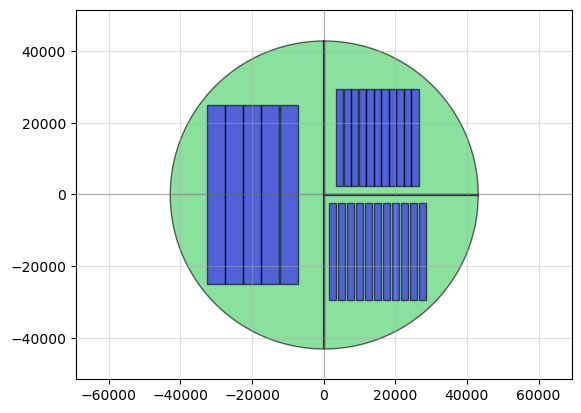

In [2]:


def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    # Create an array of boxes
    for row in range(num_rows):
        for col in range(num_cols):
            box_device = pg.rectangle(size=box_size, layer=1)  # Create the box
            # Calculate the position with the provided offsets
            box_x_offset = x_offset + col * (box_size[0] + spacing)
            box_y_offset = y_offset + row * (box_size[1] + spacing)
            box_device.move((box_x_offset - (num_cols * box_size[0] + (num_cols - 1) * spacing) / 2,
                              box_y_offset - (num_rows * box_size[1] + (num_rows - 1) * spacing) / 2))  # Center the array around the provided offsets
            wafer << box_device  # Add box to the wafer layout

# Create a blank wafer layout
wafer = Device("Yuvi_wafer_optical")

# Add wafer outline
wafer_radius = 45000 - 2000
wafer << pg.circle(radius=wafer_radius, layer=0)  # Wafer outline

# Qubits  #1 
num_rows = 1             # Number of rows of boxes
num_cols = 11           # Number of columns of boxes
box_size = (2000, 27000)  # Size of each box (width, height) in micrometers
spacing = 100              # Spacing between boxes in micrometers
x_offset = 15000          # X offset for the array of boxes
y_offset = 16000          # Y offset for the array of boxes

# Create first array (Qubits) on the wafer
create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)
create_boxes(num_rows, num_cols, box_size, spacing*5, wafer, x_offset, y_offset*-1)

# Couplers 
num_rows = 1              # Number of rows of boxes
num_cols = 5              # Number of columns of boxes
box_size = (5000, 50000)  # Size of each box (width, height) in micrometers
spacing = 100              # Spacing between boxes in micrometers
x_offset = -20000          # X offset for the array of boxes
y_offset = 0         # Y offset for the array of boxes (changed to avoid overlap)

# Create second array (Couplers) on the same wafer
create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)


# finally just some lines for cleaving wafer to quadrants
create_boxes(num_rows =1, num_cols =1, box_size = (wafer_radius, 200), spacing = 0,
                         wafer = wafer, x_offset = wafer_radius/2, y_offset = 0)
# vertical
create_boxes(num_rows =1, num_cols =1, box_size = (200, wafer_radius), spacing = 0,
                         wafer = wafer, x_offset = 0, y_offset = wafer_radius/2)
create_boxes(num_rows =1, num_cols =1, box_size = (200, wafer_radius), spacing = 0,
                         wafer = wafer, x_offset = 0, y_offset = -1*wafer_radius/2)


# Optionally, display the wafer layout
qp(wafer)

In [3]:
wafer.write_gds("G:\Shared drives\SLab\Multimode\Fab\FunWithDicing\DicingTest1.dxf")

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\eeshg\AppData\Local\Temp\ipykernel_16956\268164308.py:1: SyntaxWarning: invalid escape sequence '\S'
  wafer.write_gds("G:\Shared drives\SLab\Multimode\Fab\FunWithDicing\DicingTest1.dxf")


'G:\\Shared drives\\SLab\\Multimode\\Fab\\FunWithDicing\\DicingTest1.dxf.gds'

# Round 2 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


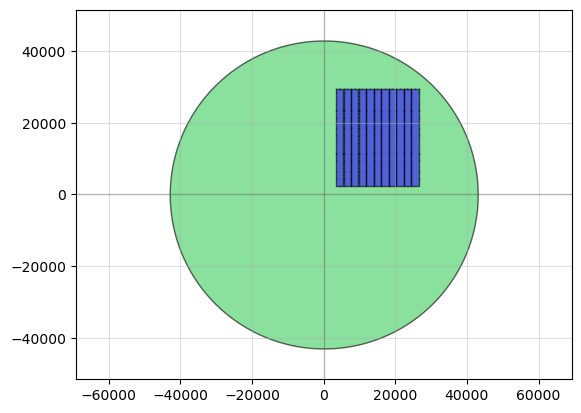

In [4]:
def create_cross(x, y, length, linewidth, wafer):
    # Create a vertical line for the cross
    vertical_line = pg.rectangle(size=(linewidth, length), layer=2)  # Vertical line
    horizontal_line = pg.rectangle(size=(length, linewidth), layer=2)  # Horizontal line

    # Position vertical line
    vertical_line.move((x - linewidth/2, y - length / 2))
    wafer << vertical_line  # Add to the wafer layout

    # Position horizontal line
    horizontal_line.move((x - length / 2, y - linewidth/2))
    wafer << horizontal_line  # Add to the wafer layout


def add_dicing_lanes(wafer, box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    # Calculate total width
    total_width = num_cols * (box_size[0] + spacing) - spacing

    # Add vertical dicing lanes
    for k in range(num_rows):
        row_y = (box_size[1] + spacing) * k  # spacing / 2
        for i in range(num_cols + 1):  # Plus one for the last lane
            x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
            num_crosses = int((box_size[1] + spacing) / 1000)  # Number of vertical crosses within each vertical dicing lane

            for j in range(num_crosses):  # Counts how many crosses to add
                loc = box_y_offset - (num_rows * (box_size[1] + spacing)) / 2 + j * 1000 + row_y
                create_cross(x, loc, 100, 20, wafer)  # vertical cross every 1mm
            
            # Add the last cross at the end of the box
            loc = box_y_offset + (num_rows * (box_size[1] + spacing)) / 2
            create_cross(x, loc, 100, 20, wafer)  # vertical cross at the end

    # Add horizontal dicing lanes
    total_height = num_rows * (box_size[1] + spacing) - spacing
    for k in range(num_cols ):  
        col_x = (box_size[0] + spacing) * k # spacing / 2
        for i in range(num_rows + 1):
            y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
            num_crosses_h = int((box_size[0] + spacing) / 1000)  # Number of horizontal crosses within each horizontal dicing lane

            for j in range(1, num_crosses_h):
                loc_x = box_x_offset - (num_cols * (box_size[0] + spacing)) / 2 + j * 1000 + col_x
                create_cross(loc_x, y, 100, 20, wafer)
                
                # # Check if the current cross would overlap with any vertical dicing crosses
                # overlap = False
                # for k in range(num_cols + 1):  # Check all vertical lanes to ensure no overlap
                #     v_x = box_x_offset - total_width / 2 + k * (box_size[0] + spacing) - spacing / 2
                #     if loc_x == v_x:  # They are in the same vertical position
                #         overlap = True
                #         break
                
                # if not overlap:  # Only create horizontal cross if no overlap
                    
                    # overlap = False  # Reset overlap for next cross

            # # Add the last cross at the end of the row
            # loc_x = box_x_offset + (num_cols * (box_size[0] + spacing)) / 2
            # create_cross(loc_x, y, 100, 20, wafer)


# Existing wafer layout code ...

# Create a blank wafer layout
wafer = Device("Yuvi_wafer_optical")

# Add wafer outline
wafer_radius = 45000 - 2000
wafer << pg.circle(radius=wafer_radius, layer=0)  # Wafer outline

# Qubits generation
num_rows = 1             # Number of rows of boxes
num_cols = 11            # Number of columns of boxes
box_size = (2000, 27000) # Size of each box (width, height) in micrometers
spacing = 100             # Spacing between boxes in micrometers
x_offset = 15000         # X offset for the array of boxes
y_offset = 16000         # Y offset for the array of boxes

# Create first array (Qubits) on the wafer
create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)

# Add dicing lanes for qubits
add_dicing_lanes(wafer, x_offset, y_offset, num_cols, spacing, box_size,num_rows)

# Create a second array (for example, for couplers) if needed
# You can add further boxes and dicing lanes as necessary following similar structure

# Finally, display the wafer layout
qp(wafer)

In [5]:
wafer.write_gds("Test.gds")

'Test.gds'

# Round 3
inverting dicing lanes so crosses are unexposed and lane is 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


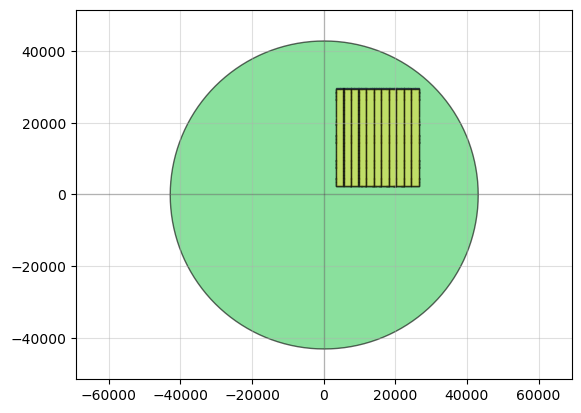

In [6]:
from phidl import Device
import phidl.geometry as pg

# Dummy create_boxes function for completeness
def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    array_width = num_cols * (box_size[0] + spacing) - spacing
    array_height = num_rows * (box_size[1] + spacing) - spacing
    start_x = x_offset - array_width / 2
    start_y = y_offset - array_height / 2
    for row in range(num_rows):
        for col in range(num_cols):
            box_geo = pg.rectangle(size=box_size, layer=99)
            box_ref = wafer << box_geo
            box_ref.xmin = start_x + col * (box_size[0] + spacing)
            box_ref.ymin = start_y + row * (box_size[1] + spacing)
    return wafer

# This function is correct and creates a centered cross.
def create_cross_device(length, linewidth):
    """
    Creates a PHIDL Device containing a single, centered cross shape.
    """
    D = Device('cross')
    vertical_bar = pg.rectangle(size=(linewidth, length))
    vertical_bar.center = (0, 0)
    D << vertical_bar
    horizontal_bar = pg.rectangle(size=(length, linewidth))
    horizontal_bar.center = (0, 0)
    D << horizontal_bar
    return D


def add_dicing_lanes(box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    """
    Creates dicing lanes with two sets of crosses:
    1. One cross precisely at each lane intersection (chip corner).
    2. Crosses at 1mm intervals along the lanes, between the corners.
    """
    lanes_to_expose = Device('LANES')
    crosses_to_subtract = Device('CROSSES')

    # --- 1. Define lane geometry ---
    total_width = num_cols * (box_size[0] + spacing) - spacing
    total_height = num_rows * (box_size[1] + spacing) - spacing
    dicing_lane_width = 100

    full_lane_width = total_width + spacing
    full_lane_height = total_height + spacing

    vertical_lane_x_coords = [box_x_offset - total_width / 2 - spacing/2 + i * (box_size[0] + spacing) for i in range(num_cols + 1)]
    horizontal_lane_y_coords = [box_y_offset - total_height / 2 - spacing/2 + i * (box_size[1] + spacing) for i in range(num_rows + 1)]

    # Create visual lane rectangles
    for x in vertical_lane_x_coords:
        lane_geo = pg.rectangle(size=(dicing_lane_width, full_lane_height), layer=1)
        lane_ref = lanes_to_expose << lane_geo
        lane_ref.center = (x, box_y_offset)

    for y in horizontal_lane_y_coords:
        lane_geo = pg.rectangle(size=(full_lane_width, dicing_lane_width), layer=1)
        lane_ref = lanes_to_expose << lane_geo
        lane_ref.center = (box_x_offset, y)

    # --- 2. Place crosses based on the two rules ---

    # RULE 1: Place one cross at every corner intersection.
    for x in vertical_lane_x_coords:
        for y in horizontal_lane_y_coords:
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # RULE 2: Place crosses at 1mm intervals BETWEEN corners.
    
    # Along Vertical Lanes
    y_start = box_y_offset - total_height/2
    num_y_steps = int(total_height / 1000)
    for x in vertical_lane_x_coords:
        for j in range(1, num_y_steps): # Range(1, N) skips the start and end points
            y = y_start + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # Along Horizontal Lanes
    x_start = box_x_offset - total_width/2
    num_x_steps = int(total_width / 1000)
    for y in horizontal_lane_y_coords:
        for j in range(1, num_x_steps): # Range(1, N) skips the start and end points
            x = x_start + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # --- 3. Perform the final boolean subtraction ---
    final_lanes = pg.boolean(
        A=lanes_to_expose,
        B=crosses_to_subtract,
        operation='not',
        layer=1
    )
    return final_lanes


# --- MAIN SCRIPT ---
wafer = Device("Yuvi_wafer_optical")
wafer << pg.circle(radius=43000, layer=0)
num_rows = 1
num_cols = 11
box_size = (2000, 27000)
spacing = 100
x_offset = 15000
y_offset = 16000

wafer = create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)
dicing_lane_geometry = add_dicing_lanes(x_offset, y_offset, num_cols, spacing, box_size, num_rows)
wafer << dicing_lane_geometry
qp(wafer)

In [7]:
wafer.write_gds("Test.gds")

'Test.gds'

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


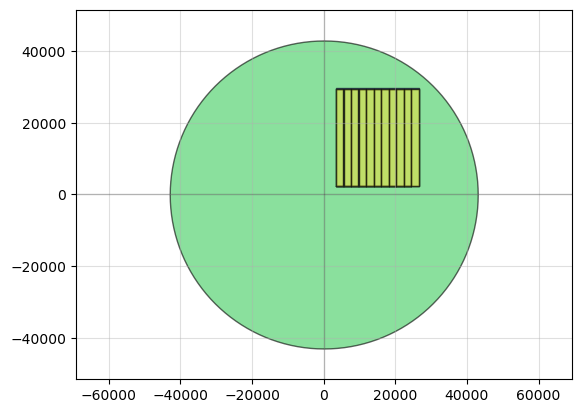

In [8]:
from phidl import Device
import phidl.geometry as pg

# Dummy create_boxes function for completeness
def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    array_width = num_cols * (box_size[0] + spacing) - spacing
    array_height = num_rows * (box_size[1] + spacing) - spacing
    start_x = x_offset - array_width / 2
    start_y = y_offset - array_height / 2
    for row in range(num_rows):
        for col in range(num_cols):
            box_geo = pg.rectangle(size=box_size, layer=99)
            box_ref = wafer << box_geo
            box_ref.xmin = start_x + col * (box_size[0] + spacing)
            box_ref.ymin = start_y + row * (box_size[1] + spacing)
    return wafer

# This function is correct and creates a centered cross.
def create_cross_device(length, linewidth):
    """
    Creates a PHIDL Device containing a single, centered cross shape.
    """
    D = Device('cross')
    vertical_bar = pg.rectangle(size=(linewidth, length))
    vertical_bar.center = (0, 0)
    D << vertical_bar
    horizontal_bar = pg.rectangle(size=(length, linewidth))
    horizontal_bar.center = (0, 0)
    D << horizontal_bar
    return D


def add_dicing_lanes(box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    """
    Creates dicing lane geometry where lanes are exposed and crosses are placed
    PRECISELY at the corners of the chip grid before being subtracted.
    """
    lanes_to_expose = Device('LANES')
    crosses_to_subtract = Device('CROSSES')

    # --- 1. Define the geometry for the exposed lanes ---
    total_width = num_cols * (box_size[0] + spacing) - spacing
    total_height = num_rows * (box_size[1] + spacing) - spacing
    dicing_lane_width = 100

    # These total lane dimensions now include the full spacing to cover the corners
    full_lane_width = total_width + spacing
    full_lane_height = total_height + spacing

    # Create vertical lane rectangles
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 - spacing/2 + i * (box_size[0] + spacing)
        lane_geo = pg.rectangle(size=(dicing_lane_width, full_lane_height), layer=1)
        lane_ref = lanes_to_expose << lane_geo
        lane_ref.center = (x, box_y_offset)

    # Create horizontal lane rectangles
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 - spacing/2 + i * (box_size[1] + spacing)
        lane_geo = pg.rectangle(size=(full_lane_width, dicing_lane_width), layer=1)
        lane_ref = lanes_to_expose << lane_geo
        lane_ref.center = (box_x_offset, y)

    # --- 2. Explicitly calculate corner coordinates and place one cross at each ---
    corner_x_coords = []
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 - spacing/2 + i * (box_size[0] + spacing)
        corner_x_coords.append(x)

    corner_y_coords = []
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 - spacing/2 + i * (box_size[1] + spacing)
        corner_y_coords.append(y)

    # Iterate through every corner and place one cross
    for x in corner_x_coords:
        for y in corner_y_coords:
            cross_ref = crosses_to_subtract << create_cross_device(50, 20)
            cross_ref.center = (x, y)

    # --- 3. Perform the final boolean subtraction ---
    final_lanes = pg.boolean(
        A=lanes_to_expose,
        B=crosses_to_subtract,
        operation='not',  # 'not' performs A - B
        layer=1
    )
    return final_lanes


# --- MAIN SCRIPT ---
wafer = Device("Yuvi_wafer_optical")
wafer << pg.circle(radius=43000, layer=0)
num_rows = 1
num_cols = 11
box_size = (2000, 27000)
spacing = 100
x_offset = 15000
y_offset = 16000

wafer = create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)
dicing_lane_geometry = add_dicing_lanes(x_offset, y_offset, num_cols, spacing, box_size, num_rows)
wafer << dicing_lane_geometry
qp(wafer)

In [9]:
wafer.write_gds("Test.gds")

'Test.gds'

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


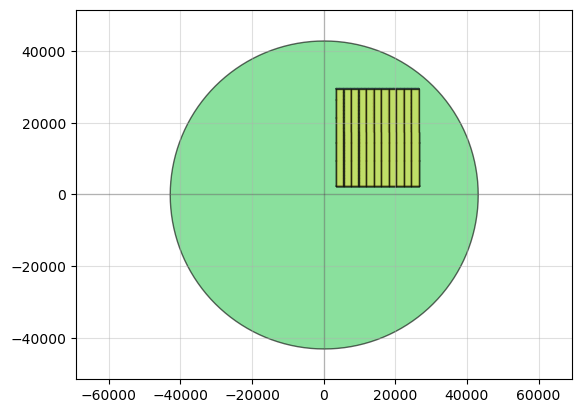

In [10]:
from phidl import Device
import phidl.geometry as pg

# Dummy create_boxes function for completeness
def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    array_width = num_cols * (box_size[0] + spacing) - spacing
    array_height = num_rows * (box_size[1] + spacing) - spacing
    start_x = x_offset - array_width / 2
    start_y = y_offset - array_height / 2
    for row in range(num_rows):
        for col in range(num_cols):
            # Create rect
            box_geo = pg.rectangle(size=box_size, layer=99)
            # Add it to get a ref
            box_ref = wafer << box_geo
            # Move the ref to its final spot, corner-to-corner
            box_ref.xmin = start_x + col * (box_size[0] + spacing)
            box_ref.ymin = start_y + row * (box_size[1] + spacing)
    return wafer

# --- THE DEFINITIVELY CORRECTED CROSS FUNCTION ---
def create_cross_device(length, linewidth):
    """
    Creates a PHIDL Device containing a single, centered cross shape.
    This is achieved by creating two rectangles and manually setting their
    centers to (0,0) to form a symmetrical cross centered at the Device origin.
    """
    D = Device('cross')

    # Create the vertical bar
    vertical_bar = pg.rectangle(size=(linewidth, length))
    # Manually center it at the origin
    vertical_bar.center = (0, 0)
    # Add the now-centered bar to the Device
    D << vertical_bar

    # Create the horizontal bar
    horizontal_bar = pg.rectangle(size=(length, linewidth))
    # Manually center it at the origin
    horizontal_bar.center = (0, 0)
    # Add the now-centered bar to the Device
    D << horizontal_bar

    return D


def add_dicing_lanes(box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    """
    Creates dicing lane geometry where lanes are exposed and crosses are unexposed
    by performing a boolean subtraction.
    """
    lanes_to_expose = Device('LANES')
    crosses_to_subtract = Device('CROSSES')

    # --- 1. Define the geometry for the exposed lanes ---
    total_width = num_cols * (box_size[0] + spacing) - spacing
    total_height = num_rows * (box_size[1] + spacing) - spacing
    dicing_lane_width = 100

    # Create vertical lane rectangles using the correct add-then-move pattern
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 - spacing/2 + i * (box_size[0] + spacing)
        lane_geo = pg.rectangle(size=(dicing_lane_width, total_height), layer=1)
        lane_ref = lanes_to_expose << lane_geo
        lane_ref.center = (x, box_y_offset)

    # Create horizontal lane rectangles using the correct add-then-move pattern
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 - spacing/2 + i * (box_size[1] + spacing)
        lane_geo = pg.rectangle(size=(total_width + spacing, dicing_lane_width), layer=1)
        lane_ref = lanes_to_expose << lane_geo
        lane_ref.center = (box_x_offset, y)

    # --- 2. Define the geometry for the unexposed crosses ---
    # Crosses in Vertical Lanes
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 - spacing/2 + i * (box_size[0] + spacing)
        num_crosses = int(total_height / 1000)
        for j in range(num_crosses + 1):
            y = box_y_offset - total_height/2 + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(50, 20)
            cross_ref.center = (x, y)

    # Crosses in Horizontal Lanes
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 - spacing/2 + i * (box_size[1] + spacing)
        num_crosses = int(total_width / 1000)
        for j in range(num_crosses + 1):
            x = box_x_offset - total_width/2 + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(50, 20)
            cross_ref.center = (x, y)

    # --- 3. Perform the boolean subtraction ---
    final_lanes = pg.boolean(
        A=lanes_to_expose,
        B=crosses_to_subtract,
        operation='not',  # 'not' performs A - B
        layer=1
    )

    return final_lanes


# --- MAIN SCRIPT ---
wafer = Device("Yuvi_wafer_optical")
wafer << pg.circle(radius=43000, layer=0)
num_rows = 1
num_cols = 11
box_size = (2000, 27000)
spacing = 100
x_offset = 15000
y_offset = 16000

wafer = create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)
dicing_lane_geometry = add_dicing_lanes(x_offset, y_offset, num_cols, spacing, box_size, num_rows)
wafer << dicing_lane_geometry
qp(wafer)

In [11]:
wafer.write_gds("Test.gds")

'Test.gds'

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


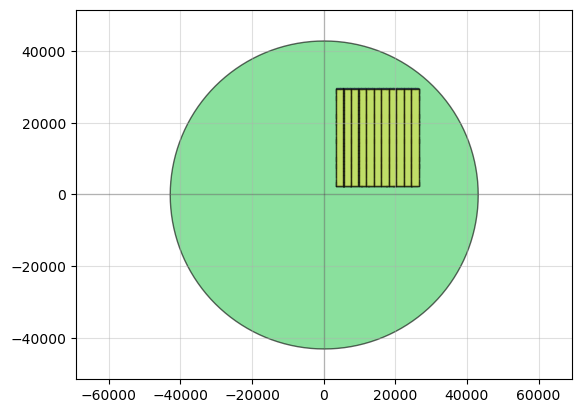

In [12]:
from phidl import Device
import phidl.geometry as pg

# Dummy create_boxes function for completeness
def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    array_width = num_cols * (box_size[0] + spacing) - spacing
    array_height = num_rows * (box_size[1] + spacing) - spacing
    start_x = x_offset - array_width / 2 + box_size[0] / 2
    start_y = y_offset - array_height / 2 + box_size[1] / 2
    for row in range(num_rows):
        for col in range(num_cols):
            box = pg.rectangle(size=box_size, layer=99)
            box.center = (start_x + col * (box_size[0] + spacing), start_y + row * (box_size[1] + spacing))
            wafer << box
    return wafer

# This function is correct as it relies on the default (0,0) centering
def create_cross_device(length, linewidth):
    """
    Creates a PHIDL Device containing a single, centered cross shape
    by overlapping two rectangles.
    """
    D = Device('cross')
    D << pg.rectangle(size=(linewidth, length))
    D << pg.rectangle(size=(length, linewidth))
    return D


def add_dicing_lanes(box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    """
    Creates dicing lane geometry where lanes are exposed and crosses are unexposed
    by performing a boolean subtraction.
    """
    lanes_to_expose = Device('LANES')
    crosses_to_subtract = Device('CROSSES')

    # --- 1. Define the geometry for the exposed lanes ---
    total_width = num_cols * (box_size[0] + spacing) - spacing
    total_height = num_rows * (box_size[1] + spacing) - spacing
    dicing_lane_width = 100

    # --- CORRECTED LANE CREATION ---
    # Create vertical lane rectangles
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
        # 1. Create the geometry
        lane_geo = pg.rectangle(size=(dicing_lane_width, total_height), layer=1)
        # 2. Add it to the parent device to get a reference
        lane_ref = lanes_to_expose << lane_geo
        # 3. Move the reference
        lane_ref.center = (x, box_y_offset)

    # Create horizontal lane rectangles
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
        # 1. Create the geometry
        lane_geo = pg.rectangle(size=(total_width, dicing_lane_width), layer=1)
        # 2. Add it to the parent device to get a reference
        lane_ref = lanes_to_expose << lane_geo
        # 3. Move the reference
        lane_ref.center = (box_x_offset, y)

    # --- 2. Define the geometry for the unexposed crosses ---
    # Crosses in Vertical Lanes
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
        num_crosses = int(total_height / 1000)
        for j in range(num_crosses + 1):
            y = box_y_offset - total_height/2 + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # Crosses in Horizontal Lanes
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
        num_crosses = int(total_width / 1000)
        for j in range(num_crosses + 1):
            x = box_x_offset - total_width/2 + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # --- 3. Perform the boolean subtraction ---
    final_lanes = pg.boolean(
        A=lanes_to_expose,
        B=crosses_to_subtract,
        operation='not',  # 'not' performs A - B
        layer=1
    )

    return final_lanes


# --- MAIN SCRIPT ---
wafer = Device("Yuvi_wafer_optical")
wafer << pg.circle(radius=43000, layer=0)
num_rows = 1
num_cols = 11
box_size = (2000, 27000)
spacing = 100
x_offset = 15000
y_offset = 16000

wafer = create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)
dicing_lane_geometry = add_dicing_lanes(x_offset, y_offset, num_cols, spacing, box_size, num_rows)
wafer << dicing_lane_geometry
qp(wafer)

In [13]:
wafer.write_gds("Test.gds")

'Test.gds'

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


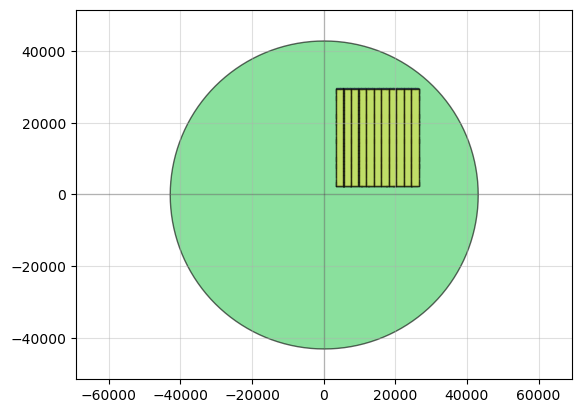

In [14]:
from phidl import Device
import phidl.geometry as pg

# This is a dummy function to allow the script to run, as it was in your original code.
# You can replace it with your actual create_boxes function.
def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    # This is a simplified centering logic for the example
    array_width = num_cols * (box_size[0] + spacing) - spacing
    array_height = num_rows * (box_size[1] + spacing) - spacing
    start_x = x_offset - array_width / 2 + box_size[0] / 2
    start_y = y_offset - array_height / 2 + box_size[1] / 2

    for row in range(num_rows):
        for col in range(num_cols):
            box = pg.rectangle(size=box_size, layer=99) # Chips on a non-interfering layer
            box.center = (start_x + col * (box_size[0] + spacing),
                          start_y + row * (box_size[1] + spacing))
            wafer << box
    return wafer

# --- DEFINITIVE CORRECTED FUNCTION ---
def create_cross_device(length, linewidth):
    """
    Creates a PHIDL Device containing a single, centered cross shape
    by overlapping two rectangles. This is the most robust method for
    creating geometry intended for boolean operations.
    """
    D = Device('cross') # Give the device a unique name
    # Add a vertical rectangle. pg.rectangle centers it at (0,0) by default.
    D << pg.rectangle(size=(linewidth, length))
    # Add a horizontal rectangle, also centered at (0,0).
    D << pg.rectangle(size=(length, linewidth))
    return D


def add_dicing_lanes(box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    """
    Creates dicing lane geometry where lanes are exposed and crosses are unexposed
    by performing a boolean subtraction.
    """
    lanes_to_expose = Device('LANES')
    crosses_to_subtract = Device('CROSSES')

    # --- 1. Define the geometry for the exposed lanes ---
    total_width = num_cols * (box_size[0] + spacing) - spacing
    total_height = num_rows * (box_size[1] + spacing) - spacing
    dicing_lane_width = 100 # Width of the dicing street

    # Create vertical lane rectangles
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
        lane = pg.rectangle(size=(dicing_lane_width, total_height), layer=1)
        lane.center = (x, box_y_offset)
        lanes_to_expose << lane

    # Create horizontal lane rectangles
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
        lane = pg.rectangle(size=(total_width, dicing_lane_width), layer=1)
        lane.center = (box_x_offset, y)
        lanes_to_expose << lane

    # --- 2. Define the geometry for the unexposed crosses ---
    # Place crosses every 1mm across the entire width/height of the chip array
    # in each dicing street.

    # Crosses in Vertical Lanes
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
        num_crosses = int(total_height / 1000)
        for j in range(num_crosses + 1):
            y = box_y_offset - total_height/2 + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # Crosses in Horizontal Lanes
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
        num_crosses = int(total_width / 1000)
        for j in range(num_crosses + 1):
            x = box_x_offset - total_width/2 + j * 1000
            cross_ref = crosses_to_subtract << create_cross_device(100, 20)
            cross_ref.center = (x, y)

    # --- 3. Perform the boolean subtraction ---
    final_lanes = pg.boolean(
        A=lanes_to_expose,
        B=crosses_to_subtract,
        operation='not',  # 'not' performs A - B
        layer=1
    )

    return final_lanes


# --- MAIN SCRIPT EXECUTION ---

# Create a blank wafer layout
wafer = Device("Yuvi_wafer_optical")

# Add wafer outline
wafer_radius = 45000 - 2000
wafer << pg.circle(radius=wafer_radius, layer=0)

# Qubits generation
num_rows = 1
num_cols = 11
box_size = (2000, 27000)
spacing = 100
x_offset = 15000
y_offset = 16000

# Create first array (Qubits) on the wafer
wafer = create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)

# Generate and add the final dicing lane geometry
dicing_lane_geometry = add_dicing_lanes(x_offset, y_offset, num_cols, spacing, box_size, num_rows)
wafer << dicing_lane_geometry

# Finally, display the wafer layout
qp(wafer)

In [15]:
wafer.write_gds("Test.gds")

'Test.gds'

In [16]:
from phidl import Device
import phidl.geometry as pg
# I've added a dummy create_boxes function since it was not provided in the last snippet
# but is used in your main script.
def create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset=0, y_offset=0):
    for row in range(num_rows):
        for col in range(num_cols):
            box = pg.rectangle(size=box_size, layer=99) # Putting chips on a different layer
            box_x = x_offset + col * (box_size[0] + spacing)
            box_y = y_offset + row * (box_size[1] + spacing)
            box.center = (box_x, box_y)
            wafer << box
    return wafer

# --- MODIFIED FUNCTIONS ---

def create_cross_device(length, linewidth):
    """
    Creates a PHIDL Device containing a single cross shape by overlapping
    two rectangles. This is more robust for boolean operations than a union.
    """
    D = Device('cross') # Give the device a name
    # Add a vertical rectangle centered at (0,0)
    D << pg.rectangle(size=(linewidth, length), center=(length/2, 0))
    # Add a horizontal rectangle centered at (0,0)
    D << pg.rectangle(size=(length, linewidth), center=(0, length/2))
    return D


def add_dicing_lanes(box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    """
    Creates dicing lane geometry where lanes are exposed and crosses are unexposed.
    This is achieved by creating two sets of geometries (lanes and crosses)
    and then performing a boolean subtraction.

    Returns:
        Device: A PHIDL Device containing the final dicing lane geometry.
    """
    lanes_to_expose = Device('LANES')
    crosses_to_subtract = Device('CROSSES')

    # --- 1. Define the geometry for the exposed lanes ---
    total_width = num_cols * (box_size[0] + spacing) - spacing
    total_height = num_rows * (box_size[1] + spacing) - spacing
    dicing_lane_width = 100 # Width of the dicing street

    # Create vertical lane rectangles
    for i in range(num_cols + 1):
        x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
        lane = pg.rectangle(size=(dicing_lane_width, total_height), layer=1)
        lane.center = (x, box_y_offset)
        lanes_to_expose << lane

    # Create horizontal lane rectangles
    for i in range(num_rows + 1):
        y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
        lane = pg.rectangle(size=(total_width, dicing_lane_width), layer=1)
        lane.center = (box_x_offset, y)
        lanes_to_expose << lane

    # --- 2. Define the geometry for the unexposed crosses ---
    # The logic here is preserved from your original code to place the crosses
    for k in range(num_rows):
        row_y = (box_size[1] + spacing) * k
        for i in range(num_cols + 1):
            x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
            num_crosses = int(box_size[1] / 1000)
            for j in range(num_crosses):
                loc_y = box_y_offset - (num_rows * (box_size[1] + spacing)) / 2 + j * 1000 + row_y
                cross = crosses_to_subtract << create_cross_device(100, 20)
                cross.center = (x, loc_y)

    for k in range(num_cols):
        col_x = (box_size[0] + spacing) * k
        for i in range(num_rows + 1):
            y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
            num_crosses_h = int(box_size[0] / 1000)
            for j in range(1, num_crosses_h):
                loc_x = box_x_offset - (num_cols * (box_size[0] + spacing)) / 2 + j * 1000 + col_x
                cross = crosses_to_subtract << create_cross_device(100, 20)
                cross.center = (loc_x, y)

    # --- 3. Perform the boolean subtraction ---
    # This subtracts the crosses from the lanes. The result is on layer 1.
    final_lanes = pg.boolean(
        A=lanes_to_expose,
        B=crosses_to_subtract,
        operation='not',  # 'not' is equivalent to A-B
        layer=1
    )

    return final_lanes


# --- MAIN SCRIPT EXECUTION ---

# Create a blank wafer layout
wafer = Device("Yuvi_wafer_optical")

# Add wafer outline
wafer_radius = 45000 - 2000
wafer << pg.circle(radius=wafer_radius, layer=0)  # Wafer outline

# Qubits generation
num_rows = 1
num_cols = 11
box_size = (2000, 27000)
spacing = 100
x_offset = 15000
y_offset = 16000

# Create first array (Qubits) on the wafer
# Centering logic in create_boxes is slightly simplified for this example
wafer = create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset - (num_cols-1)*(box_size[0]+spacing)/2, y_offset)

# --- CORRECTED USAGE ---
# 1. Generate the final dicing lane geometry using the boolean function
dicing_lane_geometry = add_dicing_lanes(x_offset, y_offset, num_cols, spacing, box_size, num_rows)

# 2. Add the resulting geometry to the main wafer
wafer << dicing_lane_geometry

# Finally, display the wafer layout
qp(wafer)

TypeError: rectangle() got an unexpected keyword argument 'center'

In [ ]:
wafer.write_gds("Test.gds")

'Test.gds'

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


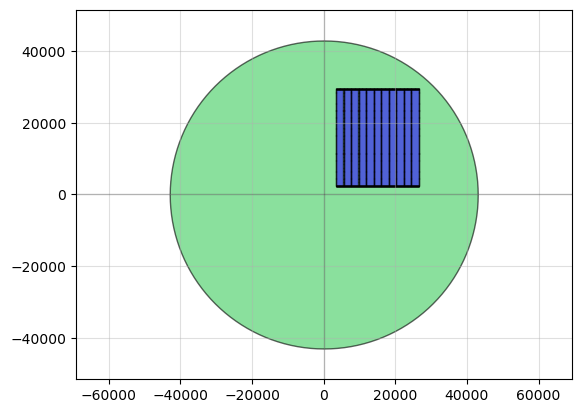

In [ ]:
def create_cross(x, y, length, linewidth, wafer):
    """
    Create a cross mark on the wafer layout that is unexposed. 
    This is achieved by creating a structure that represents
    the cut-out area for the cross itself.

    Parameters:
    x (float): The X coordinate for the center of the cross.
    y (float): The Y coordinate for the center of the cross.
    length (float): The length of the cross lines in micrometers.
    linewidth (float): The width of the cross lines in micrometers.
    wafer (Device): The wafer layout device where the shapes will be added.
    """
    # Create a vertical cut-out for the cross
    vertical_cutout = pg.rectangle(size=(linewidth, length), layer=2)  # Layer for unexposed
    vertical_cutout.move((x - linewidth / 2, y - length / 2))
    wafer << vertical_cutout  # Marked as a cut-out area for the cross

    # Create a horizontal cut-out for the cross
    horizontal_cutout = pg.rectangle(size=(length, linewidth), layer=2)  # Layer for unexposed
    horizontal_cutout.move((x - length / 2, y - linewidth / 2))
    wafer << horizontal_cutout  # Marked as a cut-out area for the cross


def add_dicing_lanes(wafer, box_x_offset, box_y_offset, num_cols, spacing, box_size, num_rows):
    # Calculate total width of the dicing lanes
    total_width = num_cols * (box_size[0] + spacing) - spacing

    # Add vertical dicing lanes
    for k in range(num_rows):
        row_y = (box_size[1] + spacing) * k
        for i in range(num_cols + 1):  # Plus one for the last lane
            x = box_x_offset - total_width / 2 + i * (box_size[0] + spacing) - spacing / 2
            lane_height = num_rows * (box_size[1] + spacing)  # Height for the entire lane
            dicing_lane = pg.rectangle(size=(20, lane_height), layer=1)  # Exposed lane layer
            dicing_lane.move((x - 10, box_y_offset - lane_height / 2))  # Center the lane vertically
            wafer << dicing_lane  # Expose the lane area

            num_crosses = int((box_size[1] + spacing) / 1000)  # Number of crosses

            for j in range(num_crosses):  # Counts how many crosses to add
                loc = box_y_offset - (num_rows * (box_size[1] + spacing)) / 2 + j * 1000 + row_y
                create_cross(x, loc, 100, 20, wafer)  # Create cutout for unexposed cross

            # Add the last cross at the end of the box
            loc = box_y_offset + (num_rows * (box_size[1] + spacing)) / 2
            create_cross(x, loc, 100, 20, wafer)  # Create cutout for unexposed cross

    # Add horizontal dicing lanes
    total_height = num_rows * (box_size[1] + spacing) - spacing
    for k in range(num_cols):
        col_x = (box_size[0] + spacing) * k
        for i in range(num_rows + 1):
            y = box_y_offset - total_height / 2 + i * (box_size[1] + spacing) - spacing / 2
            lane_width = num_cols * (box_size[0] + spacing)  # Width for the entire lane
            dicing_lane = pg.rectangle(size=(lane_width, 20), layer=1)  # Exposed lane layer
            dicing_lane.move((box_x_offset - lane_width / 2, y - 10))  # Center the lane horizontally
            wafer << dicing_lane  # Expose the lane area

            num_crosses_h = int((box_size[0] + spacing) / 1000)  # Number of horizontal crosses

            for j in range(1, num_crosses_h):  # Start from 1 to skip the first cross
                loc_x = box_x_offset - (num_cols * (box_size[0] + spacing)) / 2 + j * 1000 + col_x
                create_cross(loc_x, y, 100, 20, wafer)  # Create cutout for unexposed cross

            # Uncomment if the last cross at the end of the row is needed
            # loc_x = box_x_offset + (num_cols * (box_size[0] + spacing)) / 2
            # create_cross(loc_x, y, 100, 20, wafer)  # Create cutout for unexposed cross

# Existing wafer layout code ...

# Create a blank wafer layout
wafer = Device("Yuvi_wafer_optical")

# Add wafer outline
wafer_radius = 45000 - 2000
wafer << pg.circle(radius=wafer_radius, layer=0)  # Wafer outline

# Qubits generation
num_rows = 1             # Number of rows of boxes
num_cols = 11            # Number of columns of boxes
box_size = (2000, 27000) # Size of each box (width, height) in micrometers
spacing = 100             # Spacing between boxes in micrometers
x_offset = 15000         # X offset for the array of boxes
y_offset = 16000         # Y offset for the array of boxes

# Create first array (Qubits) on the wafer
create_boxes(num_rows, num_cols, box_size, spacing, wafer, x_offset, y_offset)

# Add dicing lanes for qubits
add_dicing_lanes(wafer, x_offset, y_offset, num_cols, spacing, box_size,num_rows)

# Create a second array (for example, for couplers) if needed
# You can add further boxes and dicing lanes as necessary following similar structure

# Finally, display the wafer layout
qp(wafer)



In [ ]:
wafer.write_gds("Test.gds")

'Test.gds'

In [ ]:
from phidl import Device
from phidl.geometry import rectangle, union, subtract

def create_cross(length, linewidth):
    """
    Create a cross shape for unexposed regions.

    Parameters:
    length (float): The length of the cross lines in micrometers.
    linewidth (float): The width of the cross lines in micrometers.
    
    Returns:
    Device: A device containing the cross shape.
    """
    # Create vertical and horizontal lines for the cross
    vertical_line = rectangle(size=(linewidth, length))
    horizontal_line = rectangle(size=(length, linewidth))

    # Combine the lines to make a cross
    cross = union([vertical_line, horizontal_line])
    return cross

def add_chips_with_borders_and_crosses(wafer, chip_array, chip_size, border_width=100):
    """
    Add an array of chips to a wafer, each surrounded by an exposed border,
    with crosses subtracted from that border.

    Parameters:
    wafer (Device): The wafer layout device where the chips will be added.
    chip_array (list of tuples): Array of (x_offset, y_offset) positions for each chip.
    chip_size (tuple): Size of each chip in micrometers (width, height).
    border_width (int): Width of the border around each chip in micrometers.
    """
    # Unpack chip size
    chip_width, chip_height = chip_size

    for (x_offset, y_offset) in chip_array:
        # Create the exposed border rectangle
        border_rect_size = (chip_width + 2 * border_width, chip_height + 2 * border_width)
        border_rectangle = rectangle(size=border_rect_size, layer=1)  # Layer 1 for exposed border
        border_rectangle.move((x_offset - border_width, y_offset - border_width))  # Center the border
        wafer << border_rectangle  # Add border to wafer
        
        # Create an empty device to hold the crosses
        crosses_device = Device('crosses')

        # Create crosses within the border
        num_crosses_x = int((border_rect_size[0] - 2 * border_width) / 1000)  # Number of crosses in width
        num_crosses_y = int((border_rect_size[1] - 2 * border_width) / 1000)  # Number of crosses in height
        
        for i in range(1, num_crosses_x + 1):
            # Position crosses inside the exposed area
            x_cross = x_offset - border_width + (i * 1000)  # Cross offsets
            for j in range(num_crosses_y + 1):
                y_cross = y_offset - border_width + (j * 1000)
                cross = create_cross(100, 20)  # Create the cross shape
                cross.move((x_cross, y_cross))  # Move to the correct position
                crosses_device.add(cross)  # Add cross to the crosses device

        # Subtract crosses from the exposed border to create unexposed areas
        final_shape = subtract(wafer['border_rectangle'], crosses_device)
        wafer << final_shape  # Add the final shape (border - crosses) to the wafer

# Example usage:
wafer = Device("Your_Wafer_Device")  # Initialize your wafer layout device
chip_array = [(0, 0), (2000, 0), (4000, 0)]  # Example chip positions (x, y) in micrometers
chip_size = (2000, 27000)  # Size of chips in micrometers

# Add chips with borders and crosses
add_chips_with_borders_and_crosses(wafer, chip_array, chip_size)

# Optionally display the wafer layout
qp(wafer)  # Quick preview of the wafer layout

ImportError: cannot import name 'subtract' from 'phidl.geometry' (c:\Users\eeshg\miniconda3\envs\klayout_env\Lib\site-packages\phidl\geometry.py)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


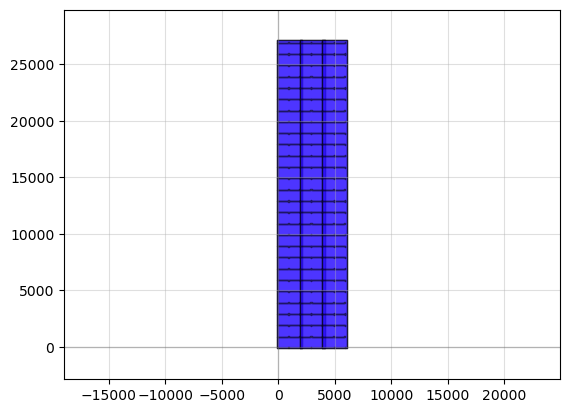

In [ ]:
from phidl import Device
from phidl.geometry import rectangle
import phidl.geometry as pg

def create_cross(length, linewidth):
    """
    Create a cross shape for unexposed regions.

    Parameters:
    length (float): The length of the cross lines in micrometers.
    linewidth (float): The width of the cross lines in micrometers.

    Returns:
    Device: A device containing the cross shape.
    """
    # Create the cross using two rectangles
    vertical_line = rectangle(size=(linewidth, length))
    horizontal_line = rectangle(size=(length, linewidth))

    # Move lines to form a cross
    vertical_line.move((0, -length / 2))
    horizontal_line.move((-length / 2, 0))

    # Create a new device for the cross
    cross_device = Device('cross')
    cross_device.add(vertical_line)
    cross_device.add(horizontal_line)

    return cross_device

def add_chips_with_borders_and_crosses(wafer, chip_array, chip_size, border_width=100):
    """
    Add an array of chips to a wafer, each surrounded by an exposed border,
    with crosses subtracted from that border.

    Parameters:
    wafer (Device): The wafer layout device where the chips will be added.
    chip_array (list of tuples): Array of (x_offset, y_offset) positions for each chip.
    chip_size (tuple): Size of each chip in micrometers (width, height).
    border_width (int): Width of the border around each chip in micrometers.
    """
    # Unpack chip size
    chip_width, chip_height = chip_size

    for (x_offset, y_offset) in chip_array:
        # Create the exposed border rectangle
        border_rect_size = (chip_width + 2 * border_width, chip_height + 2 * border_width)
        border_rectangle = rectangle(size=border_rect_size, layer=1)  # Layer 1 for exposed
        border_rectangle.move((x_offset - border_width, y_offset - border_width))  # Center it
        wafer << border_rectangle  # Expose the border area

        # Create crosses within the border
        num_crosses_x = int((border_rect_size[0] - 2 * border_width) / 1000)  # Crosses in width
        num_crosses_y = int((border_rect_size[1] - 2 * border_width) / 1000)  # Crosses in height
        
        for i in range(1, num_crosses_x + 1):  # Crosses along the width
            x_cross = x_offset - border_width + (i * 1000)  # Position crosses
            for j in range(num_crosses_y + 1):  # Crosses along the height
                y_cross = y_offset - border_width + (j * 1000)  # Position crosses
                cross_device = create_cross(100, 20)  # Create the cross shape
                cross_device.move((x_cross, y_cross))  # Move to the correct position

                # Subtract the cross from the border
                border_rectangle = pg.boolean(A = border_rectangle, B = cross_device, operation='xor', 
                                              layer = 1)  # Subtract cross

        # Add the final border shape to the wafer once crosses are subtracted
        wafer << border_rectangle

# Example usage:
wafer = Device("Your_Wafer_Device")  # Initialize your wafer layout device
chip_array = [(0, 0), (2000, 0), (4000, 0)]  # Example chip positions (x, y) in micrometers
chip_size = (2000, 27000)  # Size of chips in micrometers

# Add chips with borders and crosses
add_chips_with_borders_and_crosses(wafer, chip_array, chip_size)

# Optionally display the wafer layout
qp(wafer)  # Quick preview of the wafer layout

In [ ]:
wafer.write_gds("Test.gds")

'Test.gds'

# Adding multiple chips to wafer

In [ ]:
import sys
main_folder_path = r"C:\Users\eeshg\Documents\multimode_sims\Design\fab\LMM5_Yuvi"
sys.path.append(main_folder_path)

In [ ]:

import os
import phidl.geometry as pg
from phidl import Device, quickplot as qp
import numpy as np
from utilities import *

# Create a blank wafer layout
wafer = Device("Yuvi_wafer_optical")

# Add wafer outline (2-inch wafer = 5.08 cm = 50,800 um diameter)
wafer_radius = 45000 - 2000   # um 2mm edge bead removal
wafer << pg.circle(radius=wafer_radius, layer=0)


DeviceReference (parent Device "circle", ports [], origin (0, 0), rotation 0, x_reflection False)

# Saving

In [ ]:
wafer.write_gds("Test.gds")

'Test.gds'